In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from calibrate import *

# Gain $\eta(\nu)$

In [2]:
from test import *

In [38]:
freqs = np.linspace(1e-21,250, 32769)

In [39]:
eta_nu = eta(freqs)

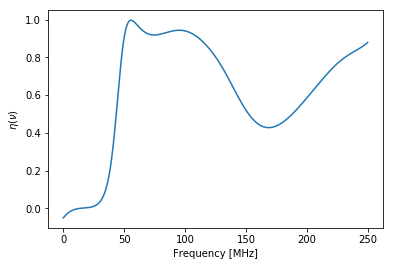

In [46]:
plt.plot(freqs,eta_nu)
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$\eta(\nu)$')
plt.savefig(impath+'efficiency.png')

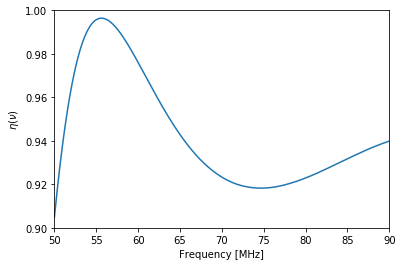

In [47]:
plt.plot(freqs,eta_nu)
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$\eta(\nu)$')
plt.xlim(50,90)
plt.ylim(0.9,1.)
plt.savefig(impath+'efficiency_50to90.png')

# Check whole data quality

In [6]:
Temps = pd.read_hdf('calibration/Days14_15.hdf5')
log_Temps = np.log10(Temps)

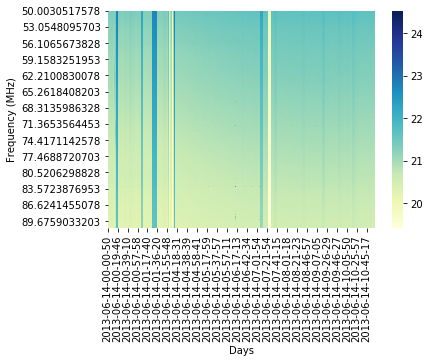

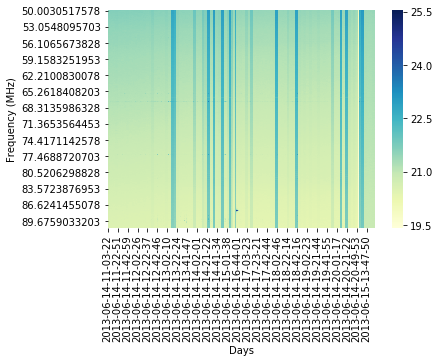

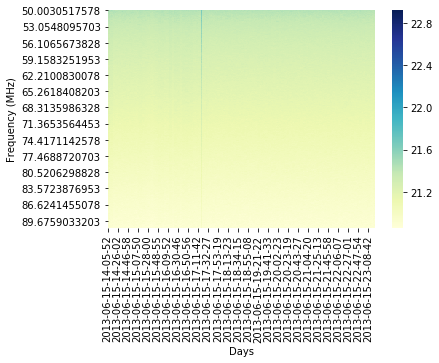

In [7]:
cols = Temps.columns.values
sb.heatmap(log_Temps[cols[0:2500]], cmap='YlGnBu', yticklabels=400)
plt.xlabel('Days')
plt.ylabel('Frequency (MHz)')
plt.savefig('Imagenes/Data_%s_%s.png'%(cols[0],cols[2500]))
plt.show()

sb.heatmap(log_Temps[cols[2500:5000]], cmap='YlGnBu', yticklabels=400)
plt.xlabel('Days')
plt.ylabel('Frequency (MHz)')
plt.savefig('Imagenes/Data_%s_%s.png'%(cols[2500],cols[5000]))
plt.show()

sb.heatmap(log_Temps[cols[5000:]], cmap='YlGnBu', yticklabels=400)
plt.xlabel('Days')
plt.ylabel('Frequency (MHz)')
plt.savefig('Imagenes/Data_%s_%s.png'%(cols[5000],cols[-1]))
plt.show()

# Check data quality

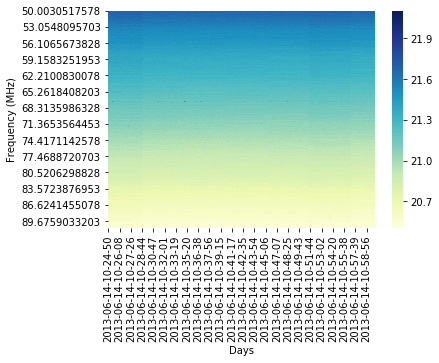

In [8]:
path = 'calibration/Days14_15.hdf5'
dates = ['2013-06-14-10-24-50','2013-06-14-10-59-52']
impath = '/home/hiram/Documentos/Tesis/Tesis_latex/Imagenes/'
Check_quality(path,dates,savepath = impath)

# Selecting Dates

In [9]:
paths = 'calibration/Days14_15.hdf5'
paths_jnc = ('calibration/Days14_15_93dBm.hdf5','calibration/Kjnc_Days14_15_93dBm.hdf5')
dates = ['2013-06-14-10-24-50','2013-06-14-10-59-52','2013-06-14 10:30:00.000','2013-06-14 11:00:00.000']

$\chi^2$

In [10]:
K_nu,Tgsm,Tmeas,Tstd = Calibrate(paths,dates)

In [11]:
freqs = np.arange(50,91)

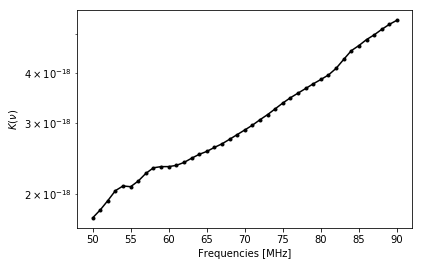

In [12]:
plt.semilogy(freqs,K_nu,'.-k')
plt.xlabel('Frequencies [MHz]')
plt.ylabel(r'$K(\nu)$')
plt.savefig(impath+'K_nu.png')

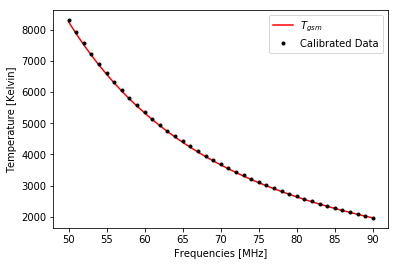

In [13]:
plt.plot(freqs,Tgsm, 'r',label=r'$T_{gsm}$')
plt.plot(freqs,K_nu*Tmeas,'.k', label = 'Calibrated Data')
plt.xlabel('Frequencies [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.legend()
plt.savefig(impath+'calibrated.png')

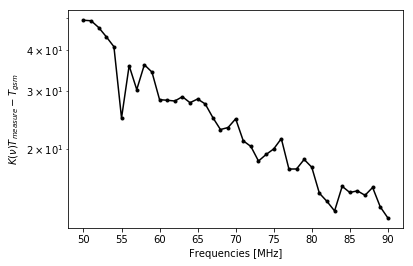

In [14]:
plt.semilogy(freqs,abs(K_nu*Tmeas - Tgsm),'.-k')
plt.xlabel('Frequencies [MHz]')
plt.ylabel(r'$K(\nu)T_{measure}-T_{gsm}$')
plt.savefig(impath+'KTmeas-Tgsm.png')

JNC

In [15]:
K_nu,Tgsm,Tmeas,Tstd = Calibrate(paths_jnc,dates,calibration='JNC')

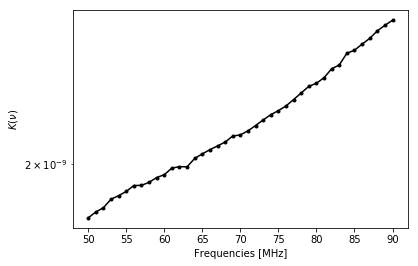

In [16]:
plt.semilogy(freqs,K_nu,'.-k')
plt.xlabel('Frequencies [MHz]')
plt.ylabel(r'$K(\nu)$')
plt.savefig(impath+'K_nu_jnc.png')

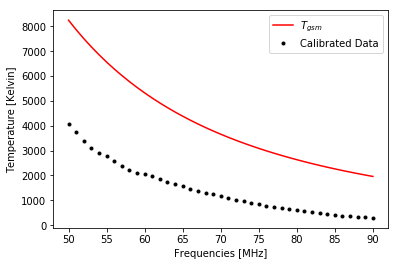

In [17]:
plt.plot(freqs,Tgsm, 'r',label=r'$T_{gsm}$')
plt.plot(freqs,K_nu*Tmeas,'.k', label = 'Calibrated Data')
plt.xlabel('Frequencies [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.legend()
plt.savefig(impath+'calibrated_jnc.png')

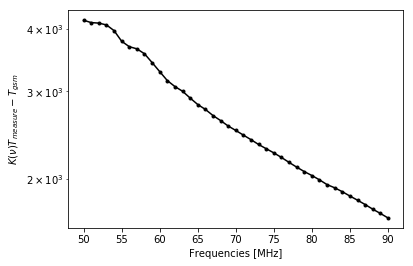

In [18]:
plt.semilogy(freqs,abs(K_nu*Tmeas - Tgsm),'.-k')
plt.xlabel('Frequencies [MHz]')
plt.ylabel(r'$K(\nu)T_{measure}-T_{gsm}$')
plt.savefig(impath+'KTmeas-Tgsm_jnc.png')

# Dates second try

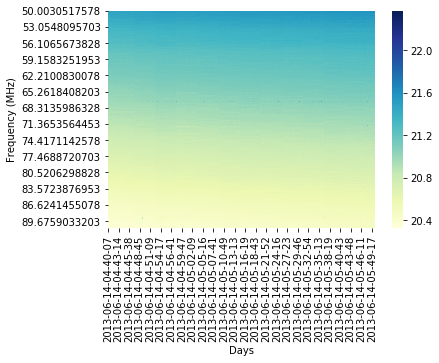

In [19]:
# Quality check
dates = ['2013-06-14-04-40-07','2013-06-14-05-50-01']
Check_quality(path,dates,savepath = impath)

In [20]:
dates = ['2013-06-14-04-40-07','2013-06-14-05-50-01','2013-06-14 04:45:00.000','2013-06-14 05:50:00.000']

$\chi^2$

In [21]:
K_nu,Tgsm,Tmeas,Tstd = Calibrate(paths,dates)

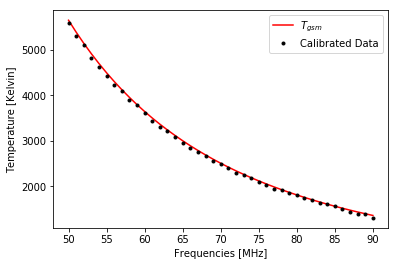

In [22]:
plt.plot(freqs,Tgsm, 'r',label=r'$T_{gsm}$')
plt.plot(freqs,K_nu*Tmeas,'.k', label = 'Calibrated Data')
plt.xlabel('Frequencies [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.legend()
plt.savefig(impath+'calibrated_2.png')

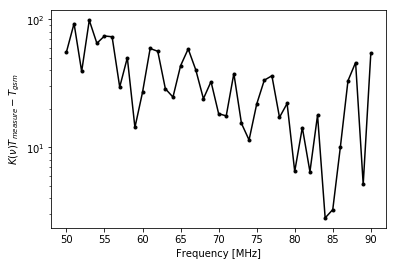

In [23]:
plt.semilogy(freqs,abs(K_nu*Tmeas - Tgsm),'.-k')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$K(\nu)T_{measure}-T_{gsm}$')
plt.savefig(impath+'KTmeas-Tgsm_2.png')

JNC

In [24]:
K_nu,Tgsm,Tmeas,Tstd = Calibrate(paths_jnc,dates,calibration='JNC')

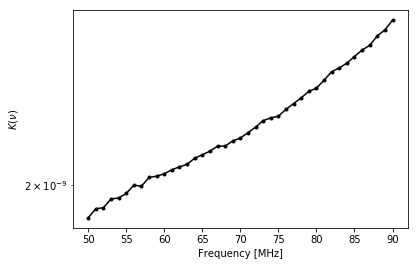

In [25]:
plt.semilogy(freqs,K_nu,'.-k')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$K(\nu)$')
plt.savefig(impath+'K_nu_jnc_2.png')

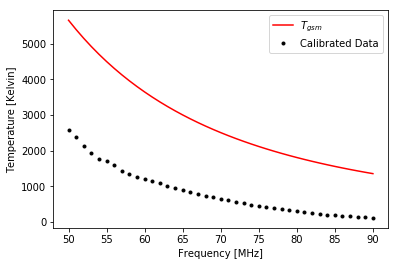

In [26]:
plt.plot(freqs,Tgsm, 'r',label=r'$T_{gsm}$')
plt.plot(freqs,K_nu*Tmeas,'.k', label = 'Calibrated Data')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.legend()
plt.savefig(impath+'calibrated_jnc_2.png')

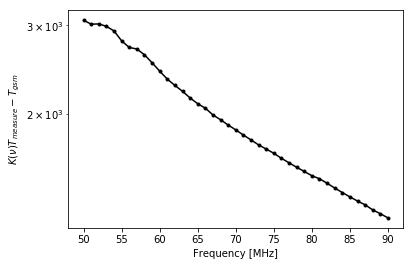

In [27]:
plt.semilogy(freqs,abs(K_nu*Tmeas - Tgsm),'.-k')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$K(\nu)T_{measure}-T_{gsm}$')
plt.savefig(impath+'KTmeas-Tgsm_jnc_2.png')

# More dates...

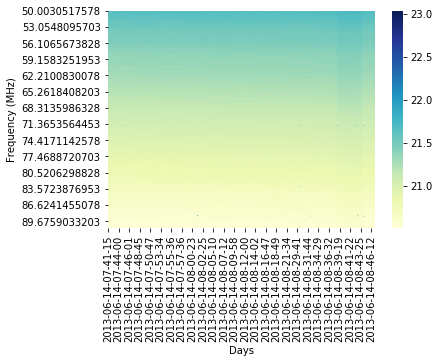

In [28]:
# Quality check
dates = ['2013-06-14-07-41-15','2013-06-14-08-46-57']
Check_quality(path,dates,savepath = impath)

In [29]:
dates = ['2013-06-14-07-41-15','2013-06-14-08-46-57','2013-06-14 07:45:00.000','2013-06-14 08:50:00.000']

$\chi^2$

In [30]:
K_nu,Tgsm,Tmeas,Tstd = Calibrate(paths,dates)

calibrate.py:70: RuntimeWarning: divide by zero encountered in divide
  Chi = (Tgsm- k*Tmeas/1.e19)**2./(error/1.e19)**2.
/home/hiram/anaconda2/lib/python2.7/site-packages/scipy/optimize/optimize.py:643: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


/home/hiram/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1e-19, top=1e-19
  'bottom=%s, top=%s') % (bottom, top))


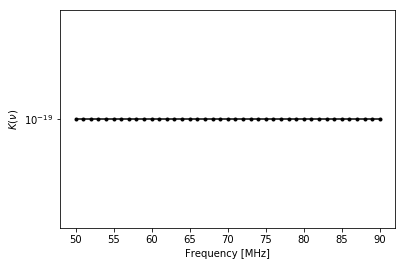

In [31]:
plt.semilogy(freqs,K_nu,'.-k')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$K(\nu)$')
plt.savefig(impath+'K_nu_3.png')

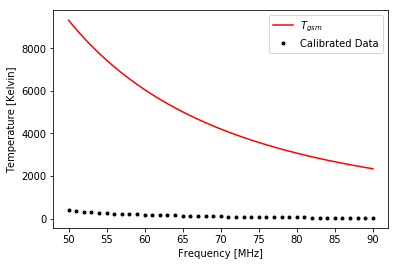

In [32]:
plt.plot(freqs,Tgsm, 'r',label=r'$T_{gsm}$')
plt.plot(freqs,K_nu*Tmeas,'.k', label = 'Calibrated Data')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.legend()
plt.savefig(impath+'calibrated_3.png')

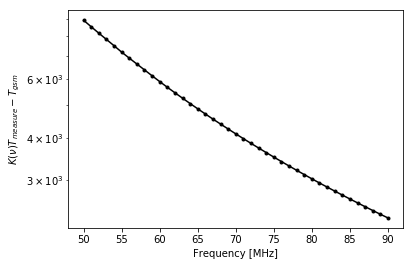

In [33]:
plt.semilogy(freqs,abs(K_nu*Tmeas - Tgsm),'.-k')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$K(\nu)T_{measure}-T_{gsm}$')
plt.savefig(impath+'KTmeas-Tgsm_3.png')

JNC

In [34]:
K_nu,Tgsm,Tmeas,Tstd = Calibrate(paths_jnc,dates,calibration='JNC')

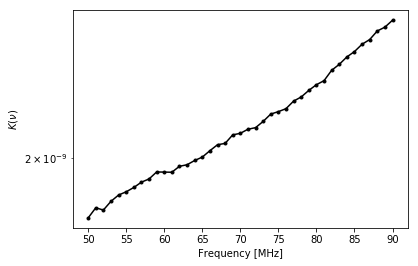

In [35]:
plt.semilogy(freqs,K_nu,'.-k')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$K(\nu)$')
plt.savefig(impath+'K_nu_jnc_3.png')

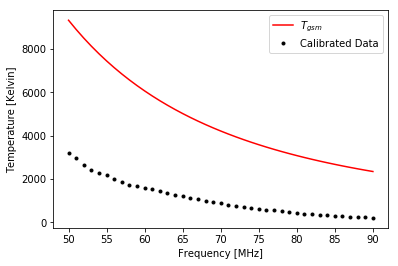

In [36]:
plt.plot(freqs,Tgsm, 'r',label=r'$T_{gsm}$')
plt.plot(freqs,K_nu*Tmeas,'.k', label = 'Calibrated Data')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.legend()
plt.savefig(impath+'calibrated_jnc_3.png')

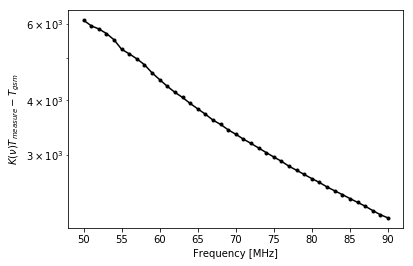

In [37]:
plt.semilogy(freqs,abs(K_nu*Tmeas - Tgsm),'.-k')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$K(\nu)T_{measure}-T_{gsm}$')
plt.savefig(impath+'KTmeas-Tgsm_jnc_3.png')